In [5]:
%matplotlib inline

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

import sys
sys.path.append('../support')
import data_functions as dfunc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style({'font.family': 'sans-serif', 
               'font.sans-serif': 'Arial Narrow', 
               'font.size': 18})

# Now how much are we losing as move from cities to MSAs

In [7]:
mergedf = pd.read_csv('../../Data/crosswalks/city_msa_crosswalk.csv',
                      dtype = {'msa': object, 'cbsa' : object}, 
                      index_col = 0)
mergedf.head()

,City,State,fipst,stategips,ucrfips,fipscounty,cbsa,msa,ssast
0,Montgomery,AL,1,1,1,1001,33860,5240,1
1,Montgomery,AL,1,1,51,1051,33860,5240,1
2,Montgomery,AL,1,1,85,1085,33860,01,1
3,Montgomery,AL,1,1,101,1101,33860,5240,1
4,Miami,FL,12,12,86,12086,33124,5000,10


In [8]:
len(mergedf.cbsa.unique())

80

In [9]:
names = [','.join(lset) for lset in mergedf.loc[:, ['cbsa', 'City', 'State']].values.tolist()]
names = list(set(names))
name_dict = {}
for nset in names:
    cnum, city, state = nset.split(',')
    loc = ','.join([city, state])
    if cnum not in name_dict:
        name_dict[cnum] = []
    name_dict[cnum].append(loc)
for cnum in name_dict:
    name_dict[cnum] = '-'.join(name_dict[cnum])
namedf = pd.DataFrame({'cbsa': list(name_dict.keys()), 'areaname':list(name_dict.values())})

In [10]:
print(name_dict)

{'47644': 'Warren,MI', '31084': 'LosAngeles,CA', '44140': 'Springfield,MA', '41180': 'SaintLouis,MO', '46140': 'Tulsa,OK', '39900': 'Reno,NV', '31140': 'Louisville,KY', '15380': 'Buffalo,NY', '28140': 'KansasCity,KS-KansasCity,MO', '48620': 'Wichita,KS', '35300': 'NewHaven,CT', '26900': 'Indianapolis,IN', '46060': 'Tucson,AZ', '12940': 'BatonRouge,LA', '41940': 'SanJose,CA', '34980': 'Nashville,TN', '24340': 'GrandRapids,MI', '39300': 'Providence,RI', '19124': 'Dallas,TX', '39340': 'Provo,UT', '47260': 'Norfolk,VA', '35644': 'NewYorkCity,NY', '19804': 'Detroit,MI', '41700': 'SanAntonio,TX', '17140': 'Cincinnati,OH', '23060': 'FortWayne,IN', '49340': 'Worcester,MA', '33460': 'Minneapolis,MN-SaintPaul,MN', '17460': 'Cleveland,OH', '27260': 'Jacksonville,FL', '41740': 'SanDiego,CA', '31540': 'Madison,WI', '30700': 'Lincoln,NE', '44180': 'Springfield,MO', '35380': 'NewOrleans,LA', '12260': 'Augusta,GA', '32820': 'Memphis,TN', '30460': 'Lexington,KY', '14484': 'Boston,MA', '30780': 'LittleR

## So we lose 11 (from 88 to ~~77~~ 79) areas, and our city population counts will be off.....

Let's proceed and start merging it all up

In [6]:
gdf = mergedf.groupby('cbsa')

In [7]:
cbsa_numbers = list(gdf.groups.keys())
print( len(cbsa_numbers) )

80


# ~~Load the census data because populatoin from the ucr can't be trusted~~

Yeah, no. The census data is way too off because of the movement from city to MSA. Don't bother

#  Now I want to load the ucr data

In [8]:
dfset = []
for fname in glob.glob('../../Data/ucr_clean/*.csv'):
    tdf = pd.read_csv(fname, index_col = 0, low_memory = False,
                      dtype = {17: object })
    tdf['year'] = int(fname.split('_')[-1].split('.csv')[0])
    dfset.append(tdf)
ucrdf = pd.concat(dfset)
ucrdf.msa = ucrdf.msa.astype(object)

## Info

* ORI is originating office, most reliable but would have to create ori to city
* ICPSR has datasets that would connect this to census data
* City core is reliable...but nowhere to match to
* Need to watch 9/12 months
* pop1, 2, and 3 will hold population.


In [9]:
# for i, (c, v) in enumerate( zip(ucrdf.columns, ucrdf.iloc[0]) ):
#     print(i, v, c)

# The 'msa' in the ucrdf is actually the 'ucrfips' in my mergedf

In [10]:
ucrdf.rename(columns = {"msa": "ucrfips"}, inplace=True)
subucrdf = ucrdf[ucrdf.ucrfips.isin(mergedf.ucrfips)]
ucrdf.ucrfips = ucrdf.ucrfips.astype(object, inplace=True)

# Great. 
So now we need to go through and create a dataframe of yearly counts of existence and the total count

In [11]:
ucr_rows = {}
for cbsa_key, row_indices in gdf.groups.items():
    ucr_rows[cbsa_key] = []
    #Get the ucrfips for the cbsa key
    ufips = mergedf.iloc[row_indices].ucrfips.values.tolist()
    #Add all of the rows for each cbsa key to a list
    for ufip in ufips:
        ucr_rows[cbsa_key].append(ucrdf[ucrdf.ucrfips == ufip])
#Turn the fips dfset into a single dataframe for each cbsa
cbsa_ucrdf = {}
for cbsa_key, cbsa_dfset in ucr_rows.items():
    cbsa_ucrdf[cbsa_key] = pd.concat(cbsa_dfset)

## Need to add all rows for the same year together

In [13]:
mo_names = [m + '_murder' for m in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec']]
#pop_names = ['population1', 'population2', 'population3']
#pop_names = ['population1']
# pop_names = ['pop1_last_census', 'pop2_last_census', 'pop3_last_census']
full_cols = mo_names

def base_cleaner(x):
    import re
    if type(x) == str:
        last_val = x.split('0')[-1]
        if last_val == '':
            return 0
        else:
            if last_val.isnumeric():
                return int(last_val)
            else:
                #print(last_val)
                return 0
    else:
        return x
    
def year_grouper(cbsadf, cbsanum):
    #Get the subset
    ygdf = cbsadf.loc[:, ['year'] + full_cols]
    #group the data frame by year and sum
    year_sum = ygdf.groupby('year').agg(sum)
    #Now we need to get the counts for MM/YY
    sums = []
    temp_sum = []
    for tyear in year_sum.index: 
        temp_sum = []
        for mo_index, mo_name in enumerate(mo_names):
            mo_sum = year_sum.loc[tyear,mo_name]
            temp_sum.append(mo_sum)
            sums.append([cbsanum, int(tyear), mo_index + 1, mo_sum])
        if len(list(set(temp_sum))) == 1 and set(temp_sum) != {0}:
            print('problem with ', cbsanum, 'year ', tyear)
            print(temp_sum)
    #Make it into a dataframe
    citydf = pd.DataFrame(sums, columns = ['cbsa', 'year', 'month', 'murder'])
    return citydf
    

# Need to give up on the population numbers from the UCR, they are completely fucked and trying to correct them will be a monumental task. The ones we have already from the census should be close enough to maintain correct order of magnitueds

In [14]:
ucr_rows = {}
for cbsa_key, row_indices in gdf.groups.items():
    ucr_rows[cbsa_key] = []
    #Get the ucrfips for the cbsa key
    ufips = mergedf.iloc[row_indices].ucrfips.values.tolist()
    #Add all of the rows for each cbsa key to a list
    for ufip in ufips:
        ucr_rows[cbsa_key].append(ucrdf[ucrdf.ucrfips == ufip])
        
#Turn the fips dfset into a single dataframe for each cbsa
cbsa_ucrdf = {}
for cbsa_key, cbsa_dfset in ucr_rows.items():
    cbsa_ucrdf[cbsa_key] = pd.concat(cbsa_dfset)
    
for cbsanum in cbsa_ucrdf:
    cbsa_ucrdf[cbsanum][mo_names] = cbsa_ucrdf[cbsanum][mo_names].applymap(base_cleaner)
    cbsa_ucrdf[cbsanum][full_cols] = cbsa_ucrdf[cbsanum][full_cols].applymap(pd.to_numeric)
    

In [15]:
city_dfset = []
cbsa_deadset = []
for cbsanum, cbsadf in list(cbsa_ucrdf.items()):
    if len(cbsadf) != 0:
        city_dfset.append( year_grouper(cbsadf, cbsanum) )
    else:
        cbsa_deadset.append(cbsanum)
        
crime_df = pd.concat(city_dfset)

In [16]:
mcrimedf = pd.merge(crime_df, mergedf, on='cbsa') 

# Now we need to merge the population data with the crime data frame

In [18]:
# fulldf = pd.merge(mcrimedf, cbsa_censusdf, on=['cbsa', 'year'])
# fulldf.head()
fulldf = mcrimedf

# Perfect - our ppopulation now seems to be in order so we can proceed

In [19]:
yeardata = fulldf.loc[:, ['cbsa', 'year']].groupby('cbsa').agg([min, max])

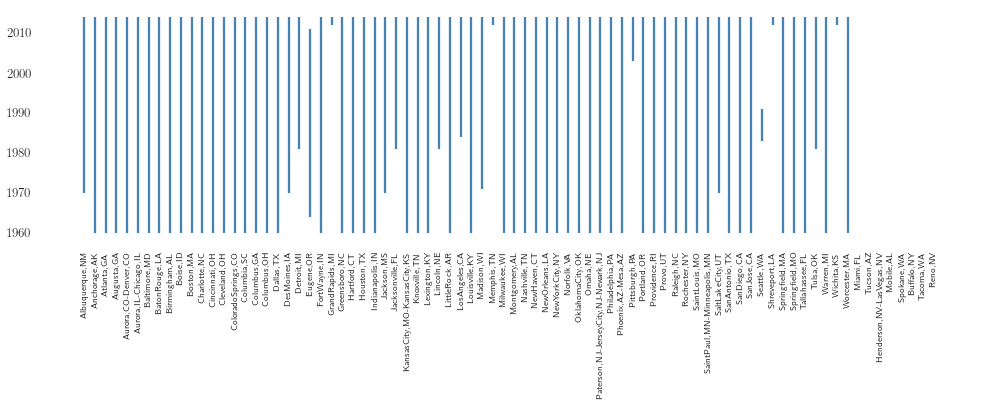

In [20]:
#Add in the deadset
xnames = yeardata.index.values.tolist()
yeardata['name'] = [name_dict[str(x)] for x in xnames]
yeardata.sort_values('name', inplace=True)
xnames = yeardata.index.values.tolist() + cbsa_deadset

ylow = yeardata.year['min'].values.tolist() + [1960 for i in cbsa_deadset]
yhigh = yeardata.year['max'].values.tolist() + [1960 for i in cbsa_deadset]

xnum = [2 * x for x in  list(range(len(xnames)))]

fig = plt.figure(figsize = (14, 6))
ax = fig.add_subplot(111, facecolor='white')
ax.vlines(xnum, ylow, yhigh, color='steelblue')
ax.set_xticks(xnum)
ax.set_xticklabels([name_dict[str(x)] for x in xnames], rotation =90, \
                   fontdict = {'fontsize': 9});
plt.tight_layout()
plt.savefig('ucr_city_timelines.eps')

# So we went from 88 to 79 in collapsing cities to CBSA
# Then we dropped from 79 to 71 when we matched with ucr records

In [ ]:
# fulldf['per_capita'] = fulldf['murder']/fulldf['population'] * 100000
# fulldf = fulldf[np.isfinite(fulldf.per_capita)]

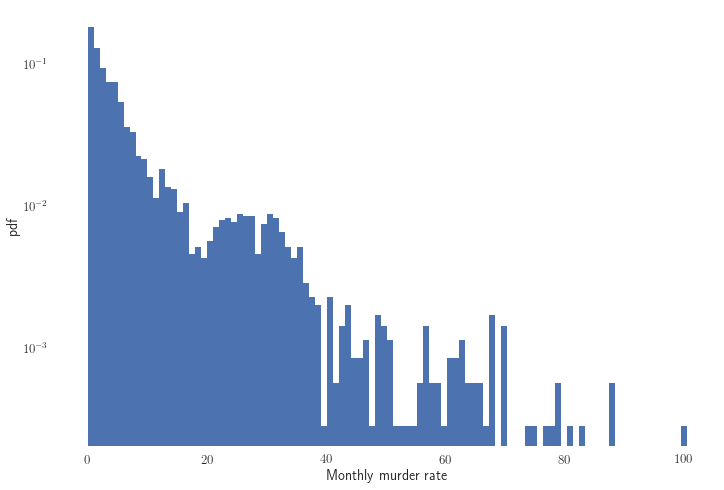

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='white')
ax = fulldf.groupby(['cbsa', 'year']).agg(np.average).murder.hist(normed=True, bins = 100, log=True, ax=ax)
ax.set_ylabel('pdf')
ax.set_xlabel('Monthly murder rate')
plt.tight_layout()
plt.savefig('figures/murder_hist.eps')

# Let's just move this to per year because hte per month is killing me

In [35]:
fulldf[(fulldf.City == 'Chicago') & (fulldf.year == 1980) & (fulldf.month == 1)]

,cbsa,year,month,murder,City,State,fipst,stategips,ucrfips,fipscounty,msa,ssast
2405,16974,1980,1,76.0,Chicago,IL,17,17,31,17031,1600,14
2406,16974,1980,1,76.0,Chicago,IL,17,17,63,17063,1600,14
2407,16974,1980,1,76.0,Chicago,IL,17,17,89,17089,1600,14
2408,16974,1980,1,76.0,Chicago,IL,17,17,93,17093,1600,14
2409,16974,1980,1,76.0,Chicago,IL,17,17,197,17197,1600,14


In [39]:
yeardf[(yeardf.cbsa == '16974') & (yeardf.year == 1980) & (yeardf.month == 2)]

,cbsa,year,month,murder
2410,16974,1980,2,70.0


In [23]:
#yearly population
yeardf = fulldf.loc[:, ['cbsa', 'year', 'month', 'murder']].drop_duplicates()
#yearly murders
yearmurderdf = yeardf.groupby(['cbsa', 'year']).agg(sum).loc[:, ['murder']].reset_index()

tcbsas, tnames = [], []
for c, n in name_dict.items():
    tcbsas.append(c)
    tnames.append(n)
citynamesdf = pd.DataFrame({'city': tnames, 'cbsa': tcbsas})
amdf = pd.merge(yearmurderdf, citynamesdf, on='cbsa')

In [40]:
amdf

,cbsa,year,murder,city
0,10740,1970,0.0,"Albuquerque,NM"
1,10740,1971,2.0,"Albuquerque,NM"
2,10740,1972,0.0,"Albuquerque,NM"
3,10740,1973,5.0,"Albuquerque,NM"
4,10740,1974,4.0,"Albuquerque,NM"
5,10740,1975,3.0,"Albuquerque,NM"
6,10740,1976,2.0,"Albuquerque,NM"
7,10740,1977,3.0,"Albuquerque,NM"
8,10740,1978,4.0,"Albuquerque,NM"
9,10740,1979,2.0,"Albuquerque,NM"


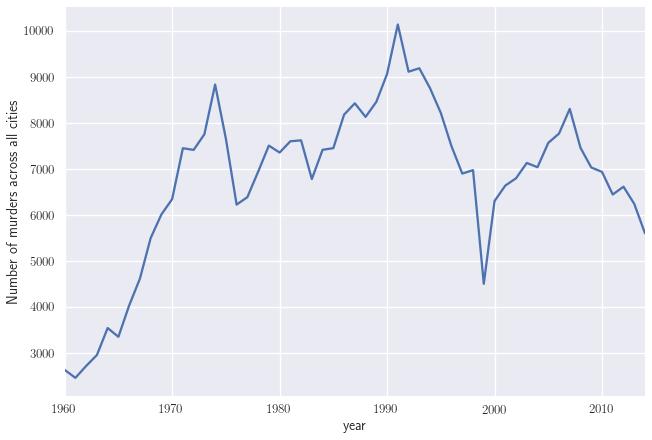

In [24]:
national = amdf.groupby('year').agg(sum)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = national.murder.plot(ax = ax)
ax.set_ylabel('Number of murders across all cities')

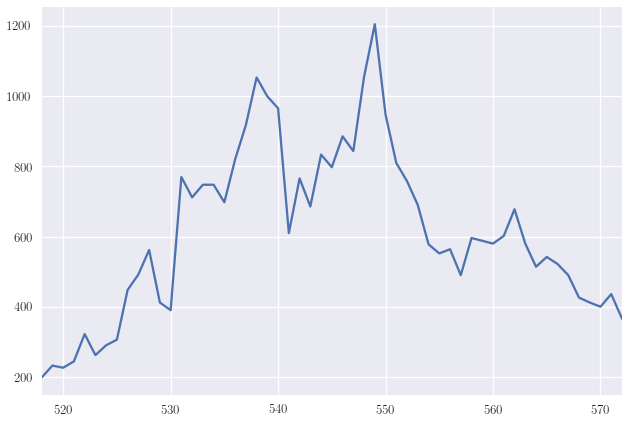

In [41]:
amdf[amdf.city == 'Aurora,IL-Chicago,IL'].murder.plot()

In [42]:
amdf.to_csv('city_annual_murder_count.csv')

In [ ]:
chicagodf = amdf[amdf.cbsa == '16974']
fig = plt.figure()
ax = fig.add_subplot(211, facecolor='white')
ax.plot(chicagodf.year, chicagodf.murder, color='steelblue')
ax.set_ylabel('Annual Murders', fontdict={'color': 'steelblue'})
ax.autoscale()


plt.tight_layout()
plt.savefig('figures/chicago_murders.eps')
plt.savefig('figures/chicago_murders.png')

In [ ]:
yeardf = amdf.groupby('cbsa').agg(max).loc[:, ['city', 'murder']].sort_values('murder', ascending=False).reset_index()

fig = plt.figure()
ax = fig.add_subplot(111, facecolor='white')
plt.bar(range(len(yeardf)), yeardf.murder)
ax.set_xticks(list(range(len(yeardf))))
ax.set_xticklabels(yeardf.city, rotation = 90, fontdict = {'fontsize':9});
ax.set_ylabel('Max Annual Murder Count')
plt.tight_layout()
plt.savefig('figures/annual_murder_count.eps')
plt.savefig('figures/annual_murder_count.png')

In [44]:
!open .